### This is a comparision between the ILP and the SSMOSP approach

#### Note: The graph data structure is stored as a JSON file 

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-19
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: AMD Ryzen 3 3250U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 51 rows, 191 columns and 474 nonzeros
Model fingerprint: 0xd2c0f5bd
Variable types: 0 continuous, 191 integer (191 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 86.0000000
Presolve removed 5 rows and 20 columns
Presolve time: 0.01s
Presolved: 46 rows, 171 columns, 422 nonzeros
Found heuristic solution: objective 99.0000000
Variable types: 0 continuous, 171 integer (171 binary)

Root relaxation: objective 2.748889e+02, 65 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

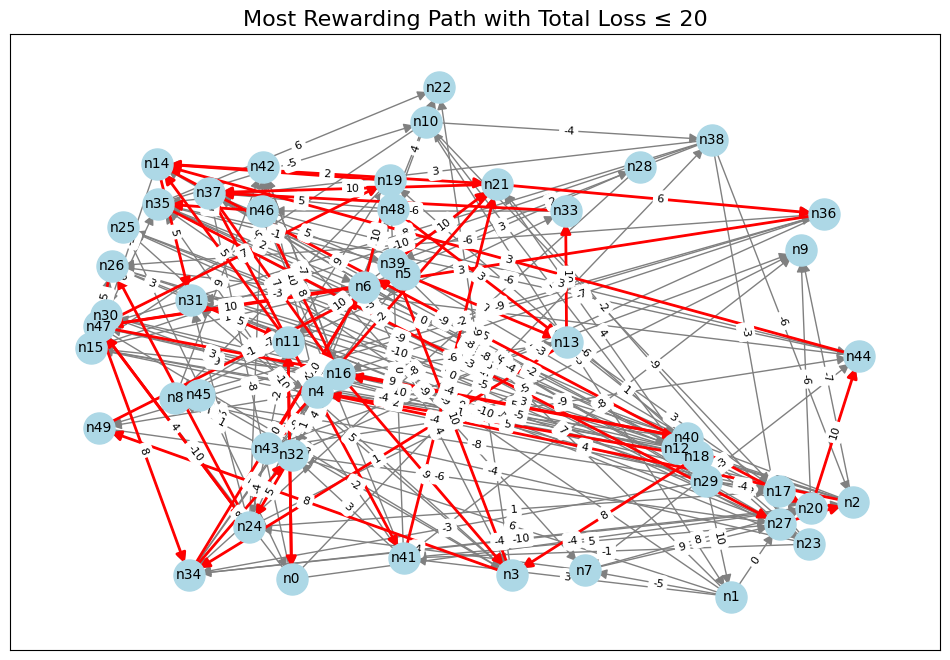

In [1]:
### This is the ILP approach
############################################ NOTE: This program randomly generates graph which might NOT necessarily be DAGs ####################################

import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt
import random
import json

# Generate a 50-node graph with random edges and weights
def generate_graph(num_nodes, num_edges):
    nodes = [f'n{i}' for i in range(num_nodes)]
    edges = {}
    for _ in range(num_edges):
        u = random.choice(nodes)
        v = random.choice(nodes)
        if u != v and (u, v) not in edges:
            weight = random.randint(-10, 10)
            edges[(u, v)] = weight
    return nodes, edges

# Parameters
num_nodes = 50
num_edges = 200
nodes, edges = generate_graph(num_nodes, num_edges)
C = 20

# Convert the tuple keys to strings for JSON compatibility
json_edges = {f"{u},{v}": weight for (u, v), weight in edges.items()}

# Save the generated graph (edges) to a JSON file for the second program
with open("graph_data.json", "w") as f:
    json.dump(json_edges, f)

# Convert edges to (reward, loss) format
converted_edges = {}
for (u, v), weight in edges.items():
    if weight > 0:
        converted_edges[(u, v)] = (weight, 0)
    else:
        converted_edges[(u, v)] = (0, -weight)

# Create a new model
m = gp.Model()

# Create variables
x = {}
for u, v in converted_edges:
    x[u, v] = m.addVar(vtype=GRB.BINARY, name=f"x_{u}_{v}")

# Set objective function to maximize total reward
m.setObjective(gp.quicksum(x[u, v] * converted_edges[u, v][0] for u, v in converted_edges), GRB.MAXIMIZE)

# Add constraints
source_node = 'n0'
target_node = f'n{num_nodes-1}'

# Constraint 1: The number of edges leaving source_node is 1
m.addConstr(gp.quicksum(x[source_node, v] for v in nodes if (source_node, v) in converted_edges) == 1, "c1")

# Constraint 2: The number of edges entering target_node is 1
m.addConstr(gp.quicksum(x[u, target_node] for u in nodes if (u, target_node) in converted_edges) == 1, "c2")

# Constraint 3: For all other vertices, the number of edges leaving them equals the number of edges entering them
for p in nodes:
    if p not in [source_node, target_node]:
        m.addConstr(
            gp.quicksum(x[p, q] for q in nodes if (p, q) in converted_edges) -
            gp.quicksum(x[r, p] for r in nodes if (r, p) in converted_edges) == 0,
            f"flow_{p}"
        )

# Constraint: The total loss should be at most C
m.addConstr(gp.quicksum(x[u, v] * converted_edges[u, v][1] for u, v in converted_edges) <= C, "loss_constraint")

# Solve the model
m.optimize()

# Extract the solution edges and calculate reward and penalty
solution_edges = []
total_reward = 0
total_negative_weight = 0

if m.status == GRB.OPTIMAL:
    for u, v in converted_edges:
        if x[u, v].X > 0.5:
            solution_edges.append((u, v))
            reward, loss = converted_edges[u, v]
            if reward > 0:
                total_reward += reward
            if loss > 0:
                total_negative_weight += loss

    # Print the best path
    print("Best path:")
    for u, v in solution_edges:
        print(f"{u} -> {v} (weight: {converted_edges[u, v][0] if converted_edges[u, v][0] > 0 else -converted_edges[u, v][1]})")

    # Print total reward and total negative weight
    print(f"Total reward: {total_reward}")
    print(f"Total negative weight: {total_negative_weight}")
else:
    print("No valid path found")

# Create the graph using networkx
G = nx.DiGraph()
for (u, v), (reward, loss) in converted_edges.items():
    G.add_edge(u, v, weight=reward if reward > 0 else -loss)

# Define positions for nodes
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=10)

# Draw all edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=15, edge_color='gray')

# Highlight the solution edges
nx.draw_networkx_edges(G, pos, edgelist=solution_edges, arrowstyle='-|>', arrowsize=15, edge_color='r', width=2)

# Draw edge labels
edge_labels = {(u, v): f"{G[u][v]['weight']}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Show the plot
plt.title(f"Most Rewarding Path with Total Loss ≤ {C}", fontsize=16)
plt.show()


### ------------------------------------------------------------------------------------------------------------------------------------------------------------

### The code for random generation is modified such that it only generates DAGs

In [30]:
### modified code so that it only generates DAGs 

import random
import gurobipy as gp
from gurobipy import GRB
import json

# Generate a DAG with random edges and weights
def generate_dag(num_nodes, num_edges):
    nodes = [f'n{i}' for i in range(num_nodes)]
    
    # Assign topological order to nodes (just shuffle them)
    topological_order = nodes.copy()
    random.shuffle(topological_order)
    
    edges = {}
    while len(edges) < num_edges:
        u, v = random.sample(topological_order, 2)
        # Ensure the edge follows topological order (u appears before v)
        if topological_order.index(u) < topological_order.index(v):
            if (u, v) not in edges:
                weight = random.randint(-100, 100)
                edges[(u, v)] = weight
    return nodes, edges

# Parameters
num_nodes = 100
num_edges = 500
nodes, edges = generate_dag(num_nodes, num_edges)
C = 50

# Save the generated graph (edges) to a JSON file for the second program
edges_str_keys = {f"{u},{v}": weight for (u, v), weight in edges.items()}
with open("graph_data.json", "w") as f:
    json.dump(edges_str_keys, f)

# Convert edges to (reward, loss) format
converted_edges = {}
for (u, v), weight in edges.items():
    if weight > 0:
        converted_edges[(u, v)] = (weight, 0)
    else:
        converted_edges[(u, v)] = (0, -weight)

# Create a new model
m = gp.Model()

# Create variables
x = {}
for u, v in converted_edges:
    x[u, v] = m.addVar(vtype=GRB.BINARY, name=f"x_{u}_{v}")

# Set objective function to maximize total reward
m.setObjective(gp.quicksum(x[u, v] * converted_edges[u, v][0] for u, v in converted_edges), GRB.MAXIMIZE)

# Add constraints
source_node = 'n0'
target_node = f'n{num_nodes-1}'

# Constraint 1: The number of edges leaving source_node is 1
m.addConstr(gp.quicksum(x[source_node, v] for v in nodes if (source_node, v) in converted_edges) == 1, "c1")

# Constraint 2: The number of edges entering target_node is 1
m.addConstr(gp.quicksum(x[u, target_node] for u in nodes if (u, target_node) in converted_edges) == 1, "c2")

# Constraint 3: For all other vertices, the number of edges leaving them equals the number of edges entering them
for p in nodes:
    if p not in [source_node, target_node]:
        m.addConstr(
            gp.quicksum(x[p, q] for q in nodes if (p, q) in converted_edges) -
            gp.quicksum(x[r, p] for r in nodes if (r, p) in converted_edges) == 0,
            f"flow_{p}"
        )

# Constraint: The total loss should be at most C
m.addConstr(gp.quicksum(x[u, v] * converted_edges[u, v][1] for u, v in converted_edges) <= C, "loss_constraint")

# Solve the model
m.optimize()

# Extract the solution edges
solution_edges = []
predecessors = {}

if m.status == GRB.OPTIMAL:
    for u, v in converted_edges:
        if x[u, v].X > 0.5:  # If the edge is selected in the optimal solution
            solution_edges.append((u, v))
            predecessors[u] = v  # Track the next node for each node

    # Reconstruct the path from the source node 'n0' to the target node
    best_path = []
    current_node = source_node

    while current_node in predecessors:
        next_node = predecessors[current_node]
        best_path.append((current_node, next_node))
        current_node = next_node

    # Print the best path in the correct order (starting from the source)
    print("Best path:")
    total_reward = 0
    total_negative_weight = 0
    for u, v in best_path:
        reward, loss = converted_edges[u, v]
        print(f"{u} -> {v} (weight: {reward if reward > 0 else -loss})")
        if reward > 0:
            total_reward += reward
        if loss > 0:
            total_negative_weight += loss

    # Print total reward and total negative weight
    print(f"Total reward: {total_reward}")
    print(f"Total negative weight: {total_negative_weight}")
else:
    print("No valid path found")


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: AMD Ryzen 3 3250U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 101 rows, 500 columns and 1239 nonzeros
Model fingerprint: 0xb8f1336e
Variable types: 0 continuous, 500 integer (500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 199.0000000
Presolve removed 101 rows and 500 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 1: 199 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.990000000000e+02, best bound 1.990000000000e+02, gap 0.0000%
Best path:
n0 -> n95 (weight: 9

### -------------------------------------------------------------------------------------------------------------------------------------------------------------

### Graph data verification (for JSON graph data)

In [31]:
import json
from collections import defaultdict

# Load the graph data
with open("graph_data.json", "r") as f:
    json_edges = json.load(f)

# Convert string keys back to tuples of node names
edges = {tuple(map(str.strip, key.split(','))): value for key, value in json_edges.items()}

# Create a graph representation
G = defaultdict(list)
for (u, v), weight in edges.items():
    u = int(u[1:])  # Convert node label from 'nX' to integer X
    v = int(v[1:])  # Same here
    G[u].append((v, weight))

# Print some statistics
print(f"Number of nodes: {len(G)}")
print(f"Number of edges: {sum(len(v) for v in G.values())}")

# Function to find all paths
def find_all_paths(graph, start, end, path=[]):
    path = path + [start]
    if start == end:
        return [path]
    if start not in graph:
        return []
    paths = []
    for node, _ in graph[start]:
        if node not in path:
            new_paths = find_all_paths(graph, node, end, path)
            for new_path in new_paths:
                paths.append(new_path)
    return paths

# Function to calculate reward and penalty for a path
def calculate_reward_penalty(graph, path):
    reward = 0
    penalty = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        weight = next(w for node, w in graph[u] if node == v)
        if weight > 0:
            reward += weight
        else:
            penalty -= weight
    return reward, penalty

# Find all paths from source to terminal
all_paths = find_all_paths(G, 0, 99)

print(f"Number of paths from 0 to 99: {len(all_paths)}")

if all_paths:
    print("All paths from 0 to 99:")
    for i, path in enumerate(all_paths, 1):
        reward, penalty = calculate_reward_penalty(G, path)
        print(f"Path {i}: {path} (Reward: {reward}, Penalty: {penalty})")

# Calculate statistics about the paths
if all_paths:
    path_stats = [(len(path), *calculate_reward_penalty(G, path)) for path in all_paths]
    
    print(f"\nPath Statistics:")
    shortest_path = min(path_stats, key=lambda x: x[0])
    longest_path = max(path_stats, key=lambda x: x[0])
    avg_nodes = sum(stat[0] for stat in path_stats) / len(path_stats)
    avg_reward = sum(stat[1] for stat in path_stats) / len(path_stats)
    avg_penalty = sum(stat[2] for stat in path_stats) / len(path_stats)
    
    print(f"Shortest path (#nodes, reward - penalty): {shortest_path[0]}, {shortest_path[1]} - {shortest_path[2]}")
    print(f"Longest path  (#nodes, reward - penalty): {longest_path[0]}, {longest_path[1]} - {longest_path[2]}")
    print(f"Average path  (#nodes, reward - penalty): {avg_nodes:.2f}, {avg_reward:.2f} - {avg_penalty:.2f}")
else:
    print("No paths found from 0 to 99")

Number of nodes: 90
Number of edges: 500
Number of paths from 0 to 99: 2
All paths from 0 to 99:
Path 1: [0, 95, 74, 99] (Reward: 199, Penalty: 0)
Path 2: [0, 52, 81, 74, 99] (Reward: 125, Penalty: 54)

Path Statistics:
Shortest path (#nodes, reward - penalty): 4, 199 - 0
Longest path  (#nodes, reward - penalty): 5, 125 - 54
Average path  (#nodes, reward - penalty): 4.50, 162.00 - 27.00


### -------------------------------------------------------------------------------------------------------------------------------------------------------------

### SSMOSP Extend and Merge Approach

In [37]:
import math
import json
from collections import defaultdict, deque

class Edge:
    def __init__(self, u, v, weight):
        self.u = u
        self.v = v
        self.weight = weight

class Graph:
    def __init__(self, nodes):
        self.V = len(nodes)
        self.adj = defaultdict(list)
        self.incoming = defaultdict(list)
        self.node_map = {name: idx for idx, name in enumerate(nodes)}
        self.reverse_node_map = {idx: name for name, idx in self.node_map.items()}

    def add_edge(self, u, v, weight):
        u_idx = self.node_map[u]
        v_idx = self.node_map[v]
        edge = Edge(u_idx, v_idx, weight)
        self.adj[u_idx].append(edge)
        self.incoming[v_idx].append(edge)

    def topological_sort(self):
        in_degree = {i: 0 for i in range(self.V)}
        for u in self.adj:
            for edge in self.adj[u]:
                in_degree[edge.v] += 1

        queue = deque([v for v in range(self.V) if in_degree[v] == 0])
        top_order = []

        while queue:
            u = queue.popleft()
            top_order.append(u)
            for edge in self.adj[u]:
                in_degree[edge.v] -= 1
                if in_degree[edge.v] == 0:
                    queue.append(edge.v)

        return top_order

def calculate_position_sqrt(q):
    return (int(math.sqrt(q[0] + 1)), int(math.sqrt(q[1] + 1)))

def calculate_position_double_log(q):
    reward_log = math.log(q[0] + 1)
    neg_weight_log = math.log(q[1] + 1)
    return (int(math.log(reward_log + 1)), int(math.log(neg_weight_log + 1)))

def ExtendAndMerge(R, Q, e, bound, calculate_position_func):
    for p in Q.values():
        if e.weight >= 0:
            q = (p[0] + e.weight, p[1], p, e)
        else:
            q = (p[0], p[1] - e.weight, p, e)
        
        if q[1] <= bound:
            pos = calculate_position_func(q)
            if pos not in R or R[pos][0] < q[0]:
                R[pos] = q

def reconstruct_path(p):
    path = []
    while p[2] is not None:
        path.append(p[3])
        p = p[2]
    return list(reversed(path))

def ModifiedSSMOSP(G, s, t, bound, calculate_position_func):
    TopOrder = G.topological_sort()
    Π = {v: {} for v in range(G.V)}
    Π[s][0] = (0, 0, None, None)

    for v in TopOrder:
        for e in G.incoming[v]:
            ExtendAndMerge(Π[v], Π[e.u], e, bound, calculate_position_func)
    
    if Π[t]:
        best_path = max(Π[t].values(), key=lambda p: p[0])
        return best_path[0], reconstruct_path(best_path)
    else:
        return None, []

# Load the JSON data generated by the previous program
with open("graph_data.json", "r") as f:
    edges = json.load(f)

nodes = list(set([u.split(",")[0] for u in edges] + [v.split(",")[1] for v in edges]))
graph = Graph(nodes)

for edge, weight in edges.items():
    u, v = edge.split(",")
    graph.add_edge(u, v, weight)

# Source, target, and bound
source = "n0"
target = f"n{len(nodes)-1}"
bound = 50  # as per the constraints

# Run ModifiedSSMOSP with the alternative `calculate_position` functions for comparison
source_idx = graph.node_map[source]
target_idx = graph.node_map[target]

print("Using Square Root Bucketing:")
max_reward_sqrt, path_sqrt = ModifiedSSMOSP(graph, source_idx, target_idx, bound, calculate_position_sqrt)
if path_sqrt:
    path_sqrt_edges = [(graph.reverse_node_map[edge.u], graph.reverse_node_map[edge.v], edge.weight) for edge in path_sqrt]
    print(f"Maximum Reward: {max_reward_sqrt}")
    print("Path:", path_sqrt_edges)
else:
    print("No feasible path found within the bound.")

print("\nUsing Double Logarithmic Bucketing:")
max_reward_double_log, path_double_log = ModifiedSSMOSP(graph, source_idx, target_idx, bound, calculate_position_double_log)
if path_double_log:
    path_double_log_edges = [(graph.reverse_node_map[edge.u], graph.reverse_node_map[edge.v], edge.weight) for edge in path_double_log]
    print(f"Maximum Reward: {max_reward_double_log}")
    print("Path:", path_double_log_edges)
else:
    print("No feasible path found within the bound.")


Using Square Root Bucketing:
Maximum Reward: 199
Path: [('n0', 'n95', 95), ('n95', 'n74', 33), ('n74', 'n99', 71)]

Using Double Logarithmic Bucketing:
Maximum Reward: 199
Path: [('n0', 'n95', 95), ('n95', 'n74', 33), ('n74', 'n99', 71)]


### -------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Original SSMOSP Approach Implementation

In [39]:
import math
import json
from collections import defaultdict, deque

class Edge:
    def __init__(self, u, v, weight):
        self.u = u
        self.v = v
        self.weight = weight

class Graph:
    def __init__(self, nodes):
        self.V = len(nodes)
        self.adj = defaultdict(list)
        self.incoming = defaultdict(list)
        self.node_map = {name: idx for idx, name in enumerate(nodes)}
        self.reverse_node_map = {idx: name for name, idx in self.node_map.items()}

    def add_edge(self, u, v, weight):
        u_idx = self.node_map[u]
        v_idx = self.node_map[v]
        edge = Edge(u_idx, v_idx, weight)
        self.adj[u_idx].append(edge)
        self.incoming[v_idx].append(edge)

    def topological_sort(self):
        in_degree = {i: 0 for i in range(self.V)}
        for u in self.adj:
            for edge in self.adj[u]:
                in_degree[edge.v] += 1

        queue = deque([v for v in range(self.V) if in_degree[v] == 0])
        top_order = []

        while queue:
            u = queue.popleft()
            top_order.append(u)
            for edge in self.adj[u]:
                in_degree[edge.v] -= 1
                if in_degree[edge.v] == 0:
                    queue.append(edge.v)

        return top_order

def calculate_position_custom(q, min_reward, r):
    reward_ratio = q[0] / min_reward
    return int(math.log(reward_ratio + 1) / math.log(r))

def ExtendAndMerge(R, Q, e, bound, calculate_position_func, min_reward, r):
    for p in Q.values():
        if e.weight >= 0:
            q = (p[0] + e.weight, p[1], p, e)
        else:
            q = (p[0], p[1] - e.weight, p, e)
        
        if q[1] <= bound:
            pos = calculate_position_func(q, min_reward, r)
            if pos not in R or R[pos][0] < q[0]:
                R[pos] = q

def reconstruct_path(p):
    path = []
    while p[2] is not None:
        path.append(p[3])
        p = p[2]
    return list(reversed(path))

def ModifiedSSMOSP(G, s, t, bound, calculate_position_func, r):
    TopOrder = G.topological_sort()
    Π = {v: {} for v in range(G.V)}
    Π[s][0] = (0, 0, None, None)

    # Calculate minimum reward across all edges in the graph
    min_reward = abs(min(edge.weight for edges in G.adj.values() for edge in edges))

    for v in TopOrder:
        for e in G.incoming[v]:
            ExtendAndMerge(Π[v], Π[e.u], e, bound, calculate_position_func, min_reward, r)
    
    if Π[t]:
        best_path = max(Π[t].values(), key=lambda p: p[0])
        return best_path[0], reconstruct_path(best_path)
    else:
        return None, []

# Load the JSON data generated by the previous program
with open("graph_data.json", "r") as f:
    edges = json.load(f)

nodes = list(set([u.split(",")[0] for u in edges] + [v.split(",")[1] for v in edges]))
graph = Graph(nodes)

for edge, weight in edges.items():
    u, v = edge.split(",")
    graph.add_edge(u, v, weight)

# Source, target, bound, and approximation ratio
source = "n0"
target = f"n{len(nodes)-1}"
bound = 50  # as per the constraints
approximation_ratio = 2  # user-defined error ratio

# Run ModifiedSSMOSP with the new `calculate_position_custom` function
source_idx = graph.node_map[source]
target_idx = graph.node_map[target]

print("Using Custom Logarithmic Bucketing:")
max_reward, path = ModifiedSSMOSP(graph, source_idx, target_idx, bound, calculate_position_custom, approximation_ratio)
if path:
    path_edges = [(graph.reverse_node_map[edge.u], graph.reverse_node_map[edge.v], edge.weight) for edge in path]
    print(f"Maximum Reward: {max_reward}")
    print("Path:", path_edges)
else:
    print("No feasible path found within the bound.")


Using Custom Logarithmic Bucketing:
Maximum Reward: 199
Path: [('n0', 'n95', 95), ('n95', 'n74', 33), ('n74', 'n99', 71)]


In [1]:
import time
import cProfile
import pstats

# Start timing
start_time = time.time()

# Profile the code
profiler = cProfile.Profile()
profiler.enable()

### modified code so that it only generates DAGs 

import random
import gurobipy as gp
from gurobipy import GRB
import json

# Generate a DAG with random edges and weights
def generate_dag(num_nodes, num_edges):
    nodes = [f'n{i}' for i in range(num_nodes)]
    
    # Assign topological order to nodes (just shuffle them)
    topological_order = nodes.copy()
    random.shuffle(topological_order)
    
    edges = {}
    while len(edges) < num_edges:
        u, v = random.sample(topological_order, 2)
        # Ensure the edge follows topological order (u appears before v)
        if topological_order.index(u) < topological_order.index(v):
            if (u, v) not in edges:
                weight = random.randint(-100, 100)
                edges[(u, v)] = weight
    return nodes, edges

# Parameters
num_nodes = 10000
num_edges = 500000
nodes, edges = generate_dag(num_nodes, num_edges)
C = 1000

# Save the generated graph (edges) to a JSON file for the second program
edges_str_keys = {f"{u},{v}": weight for (u, v), weight in edges.items()}
with open("graph_data.json", "w") as f:
    json.dump(edges_str_keys, f)

# Convert edges to (reward, loss) format
converted_edges = {}
for (u, v), weight in edges.items():
    if weight > 0:
        converted_edges[(u, v)] = (weight, 0)
    else:
        converted_edges[(u, v)] = (0, -weight)

# Create a new model
m = gp.Model()

# Create variables
x = {}
for u, v in converted_edges:
    x[u, v] = m.addVar(vtype=GRB.BINARY, name=f"x_{u}_{v}")

# Set objective function to maximize total reward
m.setObjective(gp.quicksum(x[u, v] * converted_edges[u, v][0] for u, v in converted_edges), GRB.MAXIMIZE)

# Add constraints
source_node = 'n0'
target_node = f'n{num_nodes-1}'

# Constraint 1: The number of edges leaving source_node is 1
m.addConstr(gp.quicksum(x[source_node, v] for v in nodes if (source_node, v) in converted_edges) == 1, "c1")

# Constraint 2: The number of edges entering target_node is 1
m.addConstr(gp.quicksum(x[u, target_node] for u in nodes if (u, target_node) in converted_edges) == 1, "c2")

# Constraint 3: For all other vertices, the number of edges leaving them equals the number of edges entering them
for p in nodes:
    if p not in [source_node, target_node]:
        m.addConstr(
            gp.quicksum(x[p, q] for q in nodes if (p, q) in converted_edges) -
            gp.quicksum(x[r, p] for r in nodes if (r, p) in converted_edges) == 0,
            f"flow_{p}"
        )

# Constraint: The total loss should be at most C
m.addConstr(gp.quicksum(x[u, v] * converted_edges[u, v][1] for u, v in converted_edges) <= C, "loss_constraint")

# Solve the model
m.optimize()

# Extract the solution edges
solution_edges = []
predecessors = {}

if m.status == GRB.OPTIMAL:
    for u, v in converted_edges:
        if x[u, v].X > 0.5:  # If the edge is selected in the optimal solution
            solution_edges.append((u, v))
            predecessors[u] = v  # Track the next node for each node

    # Reconstruct the path from the source node 'n0' to the target node
    best_path = []
    current_node = source_node

    while current_node in predecessors:
        next_node = predecessors[current_node]
        best_path.append((current_node, next_node))
        current_node = next_node

    # Print the best path in the correct order (starting from the source)
    print("Best path:")
    total_reward = 0
    total_negative_weight = 0
    for u, v in best_path:
        reward, loss = converted_edges[u, v]
        print(f"{u} -> {v} (weight: {reward if reward > 0 else -loss})")
        if reward > 0:
            total_reward += reward
        if loss > 0:
            total_negative_weight += loss

    # Print total reward and total negative weight
    print(f"Total reward: {total_reward}")
    print(f"Total negative weight: {total_negative_weight}")
else:
    print("No valid path found")



# Stop profiling
profiler.disable()

# Calculate total execution time
end_time = time.time()
total_execution_time = end_time - start_time

# Print execution time
print(f"Total Execution Time: {total_execution_time} seconds")

# Print detailed profiling statistics
#stats = pstats.Stats(profiler).sort_stats('cumulative')
#stats.print_stats()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-19
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: AMD Ryzen 3 3250U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 10001 rows, 500000 columns and 1248374 nonzeros
Model fingerprint: 0x5a767996
Variable types: 0 continuous, 500000 integer (500000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 6628 rows and 443013 columns
Presolve time: 4.94s
Presolved: 3373 rows, 56987 columns, 142078 nonzeros
Variable types: 0 continuous, 56987 integer (56987 binary)
Found heuristic solution: objective 526.0000000
Found heuristic solution: objective 711.0000000

Root simplex log...

Iteration    Objective       Primal Inf.    Dual